In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os
import yaml

from models import Classifier

In [10]:
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

datasets_path = config["directories"]["datasets_path"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

Current device: cuda:0


In [11]:
# Custom dataset with our model parameters
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        weights = torch.tensor(self.dataset.iloc[idx, :-1].values, dtype=torch.float32)
        angle = torch.tensor(self.dataset.iloc[idx, -1]/90, dtype=torch.int64)

        return weights, angle

In [12]:
dataset_name = "four_angles.csv"
dataset_path = os.path.join(datasets_path, dataset_name)

# Create a dataset
dataset = ModelParamsDataset(dataset_path)

torch.manual_seed(42)

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))

Train sample: 6400
Validation sample: 800
Test sample: 800


  0%|          | 0/20 [00:00<?, ?it/s]

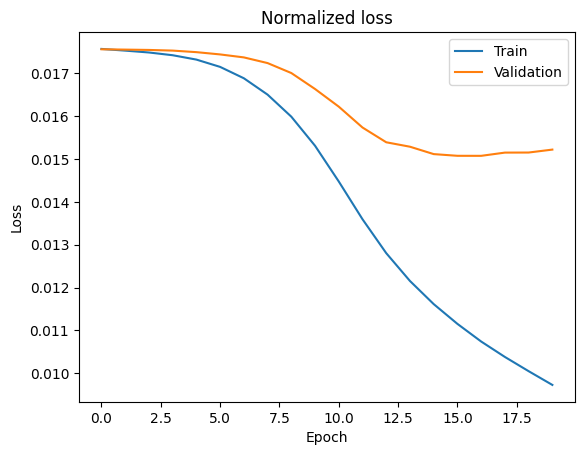

In [17]:
# TRAINING
torch.manual_seed(42)

# Hyperparameters
epochs = 20
learning_rate = 5e-5
output_dim = 4

# Logging
total_losses_train = []
total_losses_validation = []

# Training
model = Classifier(output_dim)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_losses_train.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_losses_validation.append(total_loss)


# Plot the losses
total_losses_train = np.array(total_losses_train)/len(dataset_train)
total_losses_validation = np.array(total_losses_validation)/len(dataset_valid)

plt.plot(total_losses_train, label="Train")
plt.plot(total_losses_validation, label="Validation")
plt.legend()
plt.title("Normalized loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

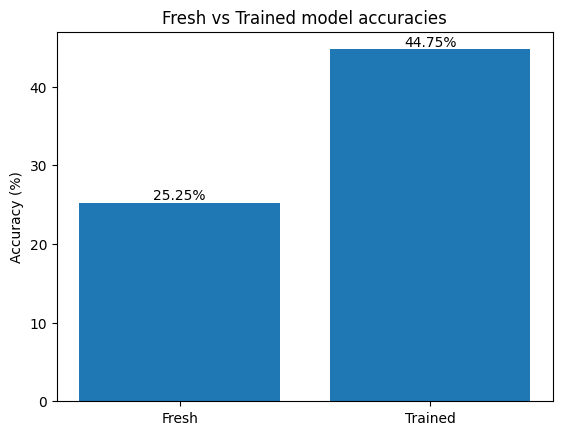

In [28]:
torch.random.manual_seed(42)
model_fresh = Classifier(output_dim)
model_fresh.to(device)

total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_fresh = total_correct / len(dataset_test) * 100
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataset_test) * 100

plt.title("Fresh vs Trained model accuracies")
plt.bar(["Fresh", "Trained"], [accuracy_fresh.cpu().detach().numpy(), accuracy_trained.cpu().detach().numpy()])
plt.ylabel("Accuracy (%)")
plt.text(0, accuracy_fresh.cpu().detach().numpy(), f"{accuracy_fresh.cpu().detach().numpy():.2f}%", ha='center', va='bottom')
plt.text(1, accuracy_trained.cpu().detach().numpy(), f"{accuracy_trained.cpu().detach().numpy():.2f}%", ha='center', va='bottom')
plt.show()